In [2]:
import torch as torch
from torch import nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import einops as eo
from torch.utils.data import Dataset, DataLoader, IterableDataset
from tqdm import tqdm

In [3]:
class Iterable2DPoints(Dataset):
    def __init__(self, means=torch.tensor([[-2,2], [2, 2], [0, -2]]), 
                       stds=torch.tensor([0.2, 0.1, 0.3]), 
                       weight=torch.tensor([1/3,1/3,1/3]), 
                       n=int(1e12)):
        super().__init__()
        self.means = means
        self.stds = stds
        self.weight = weight
        self.borders = []
        for w in weight:
            if len(self.borders) == 0:
                self.borders += [w]
            else:
                self.borders += [w+self.borders[-1]]
        self.borders = torch.tensor(self.borders)
        self.n=n
    
    def __getitem__(self, idx):
        rnd = torch.rand(1)[0].item()
        for idx, border in enumerate(self.borders):
            if rnd < border:
                return torch.randn(2)*self.stds[idx]+self.means[idx]
    
    def __len__(self):
        return self.n

In [4]:
dataset = Iterable2DPoints()
iterator = iter(dataset)
X = []
for i in tqdm(range(100)):
    x = next(iterator)
    X += [x]
X = torch.stack(X)

100%|██████████| 100/100 [00:00<00:00, 36817.98it/s]


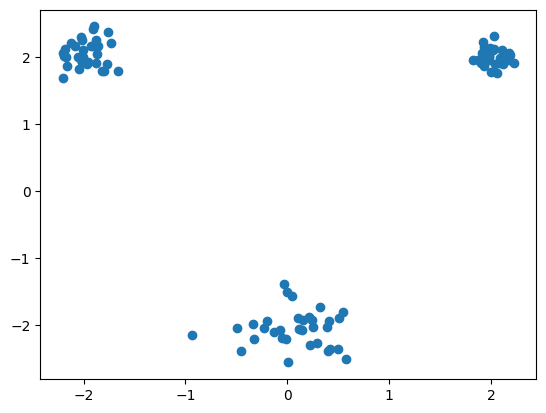

In [5]:
def viz(X):
    plt.scatter(X[:,0],X[:,1])
    plt.show()

viz(X)

In [6]:
class SimpleFlowMatcher(nn.Module):
    def __init__(self, d_data=2, d_model=64, act_fn=F.gelu):
        super().__init__()
        self.d_data = d_data
        self.d_model = d_model
        self.up_proj = nn.Linear(self.d_data, self.d_model)
        self.up_gate = nn.Linear(self.d_data, self.d_model)
        self.body = nn.Linear(self.d_model, self.d_model)
        self.down_proj = nn.Linear(self.d_model, self.d_data)
        self.act_fn = act_fn
    
    def forward(self, x):
        h1 = self.up_proj(x)
        h2 = self.up_gate(x)
        h = h1*self.act_fn(h2, inplace=True)
        #h = self.body(h)
        #h = self.act_fn(h, inplace=True)
        v = self.down_proj(h)
        return v

class SimpleFlowMatcherPlusLoss(nn.Module):
    def __init__(self, d_data=2, d_model=64, act_fn=F.leaky_relu):
        super().__init__()
        self.v = SimpleFlowMatcher(d_data=d_data, d_model=d_model, act_fn=act_fn)
    
    def forward(self, x, v_gt):
        v_pred = self.v(x)
        loss = F.mse_loss(v_pred, v_gt)
        return {'loss':loss, 'pred':v_pred}

In [7]:
#x = t.rand(100)*2 - 1
#y = t.sigmoid(x)

In [8]:
model = SimpleFlowMatcherPlusLoss()
device = 'mps'
model.to(device)
t = F.sigmoid(torch.rand(1, device=device))
eps = torch.randn(2, device=device)
x = x.to(device)
v = x - eps
x_t = x - t*v
out = model(x_t, v)
print(out)

{'loss': tensor(3.5009, device='mps:0', grad_fn=<MseLossBackward0>), 'pred': tensor([ 0.1596, -0.0112], device='mps:0', grad_fn=<LinearBackward0>)}


In [9]:
from collections import defaultdict 

class Logger():
    def __init__(self):
        self.logs = defaultdict(list)
    
    def log(self, key, val):
        self.logs[key] += [val]

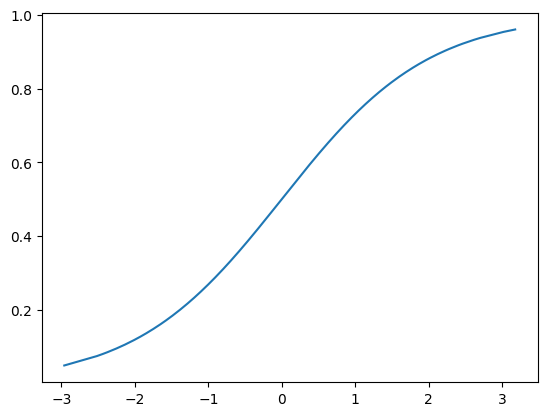

In [10]:
x = torch.randn(1000).msort()
t = F.sigmoid(x)
plt.plot(x, t)

In [11]:
@torch.no_grad()
def sample(v, x, num_steps=10, uniform=True):
    if uniform: 
        ts = 1 - torch.linspace(0, 1, num_steps)
    else:
        ts = 1 - F.sigmoid(torch.randn(num_steps).msort())
    #print(ts)
    x_prev = x.clone()
    for i in tqdm(range(len(ts)-1)):
        x_prev = x_prev + (ts[i] - ts[i+1])*v(x_prev) 
    return x_prev

# Train

100%|██████████| 1000/1000 [00:16<00:00, 59.45it/s, loss 2.0056 lr 0.0000]


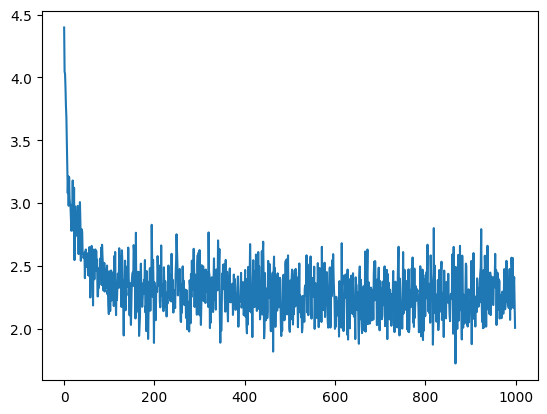

In [12]:
uniform = False
n_steps = 1000
lr = 1e-3
min_lr = 0
weight_decay = 1e-7
batch_size = 512 # 2**9 -> 2000
model = SimpleFlowMatcherPlusLoss(d_model=512)
device = 'mps'
model.to(device)
dataset = Iterable2DPoints()
loader = DataLoader(dataset, batch_size=batch_size)
opt = torch.optim.AdamW(params=model.parameters(), lr=lr, weight_decay=weight_decay)
#scheduler = torch.optim.lr_scheduler.LinearLR(optimizer=opt, total_iters=n_steps)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=opt, T_max=n_steps)
logger = Logger()
iterator = iter(loader)

pbar = tqdm(range(n_steps))
for i in pbar:
    opt.zero_grad()
    x = next(iterator)
    x = x.to(device)
    if uniform: 
        t = torch.rand((x.shape[0], 1), device=device)
    else:
        t = F.sigmoid(torch.randn((x.shape[0], 1), device=device))
    eps = torch.randn((x.shape[0], 2), device=device)
    v = x - eps
    x_t = x - t*v
    out = model(x_t, v)
    loss = out['loss']
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
    opt.step()
    scheduler.step()
    logger.log('loss', loss.item())
    curr_lr = opt.param_groups[0]['lr']
    logger.log('lr', curr_lr)
    pbar.set_postfix_str(f'loss {loss.item():.4f} lr {curr_lr:.4f}')
    

plt.plot(logger.logs['loss'])


100%|██████████| 20/20 [00:00<00:00, 47.24it/s]


torch.Size([200, 2])


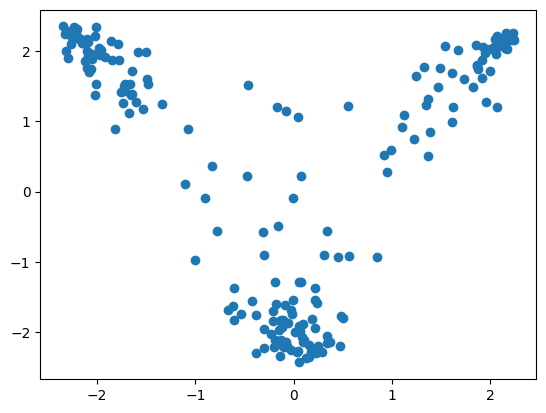

In [13]:
X_ = []
for i in tqdm(range(20)):
    x = sample(model.v, torch.randn((10, 2), device=device), num_steps=50, uniform=False)
    X_ += [x.detach().cpu()]
X_ = torch.cat(X_, dim=0)
print(X_.shape)
viz(X_)

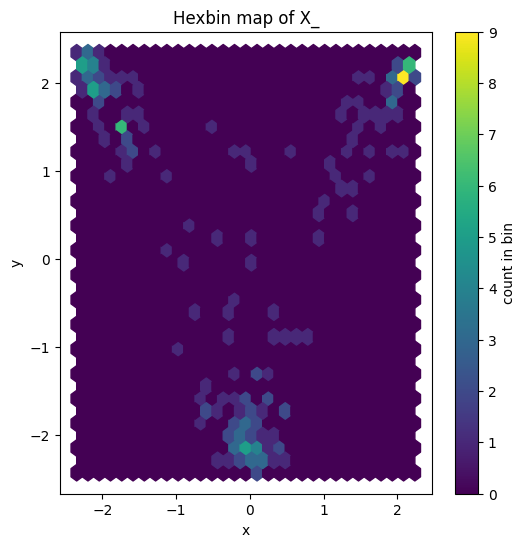

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.hexbin(X_[:, 0], X_[:, 1], gridsize=30, cmap='viridis')
plt.colorbar(label='count in bin')
plt.title('Hexbin map of X_')
plt.xlabel('x')
plt.ylabel('y')
plt.show()
